# Genome Sequencing
Authors:  
- Minh Duc Ngo  
- Catharina Hoppensack  

This notebook is our own work. Any other sources have been clearly marked and cited.

All authors contributed equally.

## 1 Environment
We worked with the following environment for this jupyter notebook:

- Python version: (3.10.19) 3.11.9  
- OS: Windows 11  
- Environment: Visual Studio Code

In [1]:
#install all basic libraries
%pip install seaborn matplotlib pandas numpy scikit-learn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

To be able to run this code on a device with GPU and CPU, the following code block is necessary.

In [3]:
#detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2 Data Loading and Inspection

_Load the dataset, inspect its structure and dimensions, and briefly describe its content._

First, we will be printing general information about our dataset. The head() function shows us the first four rows from which we get a good first impression of how the dataframe is structured. In the sequence column, we see an array of letters representing the four organic bases that make up the genetic information in DNA. The label column shows only zeros, which indicates we may need some more information.  
  
Another interesting information is the number of datasets we have. We decided to count them by saving the length information in an variable and printing it. The dataframe shows a size of 20000 datasets in which each sequence is composed of 10 letters.  
The df.info() function will give us more insights about any null entries, which data type we are dealing with and the amount of memory consumption.

In [4]:
url="https://github.com/thomasmanke/DataSets/raw/refs/heads/main/labeled_sequences.csv.gz"

df = pd.read_csv(url)
seqs = df["sequence"].tolist()
y    = df["label"].values

display(df.head())

S = len(seqs)    # number of sequences
L = len(seqs[0]) # same length for all (!!!) sequences

L = len(seqs[0])
assert all(len(s) == L for s in seqs), "different lenghts detected" #check if there are errors in sequence length

print(S)
print(L)

df.info()

,sequence,label
0,GTAGGTAAGC,0
1,GGGGTATTTG,0
2,CACTTCCCTT,0
3,AATCCATAAG,0
4,GGCTTTTGCC,0


20000
10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  20000 non-null  object
 1   label     20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


When we simply print the dataframe, we see the first and last 4 entries within the dataframe. Here we see we have another value for label (1). Another way to evaluate the size of the dataframe ist by using the shape or the ndim function. These give us information about how many rows and columns we have or in other words the dimensions of the dataframe.

In [5]:
print(df)
print(df.shape) #shape des DataFrames
print(df.ndim) #dimensionen des DataFrames

         sequence  label
0      GTAGGTAAGC      0
1      GGGGTATTTG      0
2      CACTTCCCTT      0
3      AATCCATAAG      0
4      GGCTTTTGCC      0
...           ...    ...
19995  GGGGTGAGAG      0
19996  ACCGCGACTA      0
19997  TCCTGCGAAT      0
19998  GATGCAGGCT      0
19999  ATCATTACGT      1

[20000 rows x 2 columns]
(20000, 2)
2


In [6]:
#TODO wie viele label values gibt es 

In [7]:
#Wozu dieser ganze Block??

print(type(df))
print(type(y))
print(type(y[0]))
print(type(S))
print(type(L)) 
print(type(seqs))
print(type(seqs[0]))

print(len(df[df["label"] == 1]))

onlyOne = df[df["label"] == 1]     #boolesche Maske zur Überprüfung des Labelwertes
noDuplicates = onlyOne.drop_duplicates() #warum nur für label 1 Duplikate löschen?

print(len(noDuplicates))

df_noDuplicates = df.drop_duplicates()

print(len(df))
print(len(df_noDuplicates))


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'int'>
<class 'int'>
<class 'list'>
<class 'str'>
547
543
20000
19797



- 20000 rows, 2 columns: sequence [object] , label [int]
- Das dataset beinhaltet Genomsequencen mit 20000 exemplare, wobei 19797 einzigartig sind. Also 203 dopplungen beinhaltet.
- Die Sequenz wird als String gespeichert und besteht aus 10 Buchstaben kombinatorisch aus A T C G, die Bauelemente der DNA
- adenosine, cytidine, guanosine, thymine
- Jedes Sequenzobjekt hat eine 1 oder eine 0 als Label
- 547 als label "1", darunter 4 Duplikate
- 2 Dimensionales df


### 3 Data Processing

*Transform the data into a form suitable for MLP input:*
  - *Convert to numpy / torch tensors*
  - *Flatten or reshape inputs as needed*
  - *Split into training and test sets*


A neural network can't calculate with letters. For this reason, we must assign an integer to each letter. The print outputs show the letter version compared to the integer version and the data types used.

In [8]:
#sequenz in Nummern umwandeln, denn NN kann nur mit zahlen arbeiten
mapping = str.maketrans({'A':'1','C':'2','G':'3','T':'4'})

seqs_num = [] #new list for numbers
for seq in seqs:
    mapped = seq.translate(mapping)       #"ACGT" -> "1234"
    nums = [int(x) for x in mapped]       #-> [1,2,3,4]
    seqs_num.append(nums)

In [9]:
print(seqs[0:5]) #print first 5 elements of sequence in letters
print(seqs_num[0:5]) #print first 5 elelments of sequence in numbers
print(type(seqs_num))
print(type(seqs_num[0][0]))

['GTAGGTAAGC', 'GGGGTATTTG', 'CACTTCCCTT', 'AATCCATAAG', 'GGCTTTTGCC']
[[3, 4, 1, 3, 3, 4, 1, 1, 3, 2], [3, 3, 3, 3, 4, 1, 4, 4, 4, 3], [2, 1, 2, 4, 4, 2, 2, 2, 4, 4], [1, 1, 4, 2, 2, 1, 4, 1, 1, 3], [3, 3, 2, 4, 4, 4, 4, 3, 2, 2]]
<class 'list'>
<class 'int'>


Now we want to convert our list into a NumPy-array to easily convert to PyTorch-tensors later on.

In [10]:
X_num = np.array(seqs_num, dtype=np.float32)
print(X_num.shape) #(S,L)

(20000, 10)


Here we split the data into test and train data for evaluating our model later.

In [11]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_num, y, test_size=0.2, random_state=42
)

In [12]:
X_train_tensor_num = torch.tensor(X_train_num, dtype=torch.float32)
X_test_tensor_num  = torch.tensor(X_test_num,  dtype=torch.float32)

#targets müssen float sein und 2D (N,1)
y_train_tensor_num = torch.tensor(y_train_num, dtype=torch.float32).unsqueeze(1)
y_test_tensor_num  = torch.tensor(y_test_num,  dtype=torch.float32).unsqueeze(1)

print(f'X_train_tensor.shape: {X_train_tensor_num.shape}  y_train_tensor.shape: {y_train_tensor_num.shape}')
print(f'X_test_tensor.shape:  {X_test_tensor_num.shape}   y_test_tensor.shape:  {y_test_tensor_num.shape}')

X_train_tensor.shape: torch.Size([16000, 10])  y_train_tensor.shape: torch.Size([16000, 1])
X_test_tensor.shape:  torch.Size([4000, 10])   y_test_tensor.shape:  torch.Size([4000, 1])


In [13]:
#sending all the data directly to the device
X_train_tensor_num = X_train_tensor_num.to(device)
X_test_tensor_num  = X_test_tensor_num.to(device)

y_train_tensor_num = y_train_tensor_num.to(device)
y_test_tensor_num = y_test_tensor_num.to(device)


The correct way of translating non integer values into integers is by using one-hot encoding. This makes sure that the model doesn't assume relations between categories depending on their integer value. It makes each category into a matrix as in the following example:  
A = [1,0,0,0]  
C = [0,1,0,0]  
G = [0,0,1,0]  
T = [0,0,0,1]  

In [14]:
# Some hints to convert: DNA seqs -> X
# There are other ways, but feel free to follow the recipe below
# chr -> int -> bool (one-hot encoding)
# but please make sure you understand the steps

# maps to switch chr <-> int
mapping = dict(zip("ACGT", range(4)))
idx2base = {v: k for k, v in mapping.items()}

# integer encoding of sequence: "AAGTCCA" -> [0,0,2,3,1,1,0]
seqs_int = torch.tensor([[mapping[ch] for ch in s] for s in seqs], dtype=torch.long)

# one-hot encoding of seqs_int: 
X_hot = F.one_hot(seqs_int, num_classes=4).float() 

# flatten one-hot encoding
X_hot = X_hot.view(S, 4*L)
print(f"X.shape: {X_hot.shape}, y.shape: {y.shape}, L = {L}")

X.shape: torch.Size([20000, 40]), y.shape: (20000,), L = 10


In [15]:
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(
    X_hot.numpy(), y, test_size=0.2, random_state=42
)

We convert the data to tensor.

In [16]:
X_train_tensor_hot = torch.tensor(X_train_hot, dtype=torch.float32)
X_test_tensor_hot  = torch.tensor(X_test_hot,  dtype=torch.float32)

#targets müssen float sein und 2D (N,1)
y_train_tensor_hot = torch.tensor(y_train_hot, dtype=torch.float32).unsqueeze(1)
y_test_tensor_hot  = torch.tensor(y_test_hot,  dtype=torch.float32).unsqueeze(1)

print(f'X_train_tensor.shape: {X_train_tensor_hot.shape}  y_train_tensor.shape: {y_train_tensor_hot.shape}')
print(f'X_test_tensor.shape:  {X_test_tensor_hot.shape}   y_test_tensor.shape:  {y_test_tensor_hot.shape}')

X_train_tensor.shape: torch.Size([16000, 40])  y_train_tensor.shape: torch.Size([16000, 1])
X_test_tensor.shape:  torch.Size([4000, 40])   y_test_tensor.shape:  torch.Size([4000, 1])


To be more memory efficient we can use batches that are calculated one after the other.

In [17]:
batch_size = 64

train_ds = TensorDataset(X_train_tensor_hot, y_train_tensor_hot)
test_ds  = TensorDataset(X_test_tensor_hot,  y_test_tensor_hot)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

## 4 Model Definition
_Define an appropriate MLP architecture (e.g with PyTorch nn.Sequential). Include number of layers, activation functions, and output dimensions. Report structure and number of parameters._

### Model 1 (no batches)

- 2 - 3 Layer(?)
- activation function: 
    - ReLu() _ ist standard 
    - Sigmoid _ gut für binärausgaben, Wertebereich zwischen 0 - 1
    - Binary Cross Entropy

- loss func possibilities:
    - BCEWithLogitsLoss
    - MSELoss oder MAELoss
- output ist 0 oder 1 

In [18]:
#meine Version deines Modells --> gleich viele Layers und Dropouts, nur ReLU statt SiLU
delta = 0.2
model_num = nn.Sequential(
    nn.Linear(L, 128),
    nn.ReLU(),            
    nn.Dropout(delta),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(delta),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(delta),
    nn.Linear(32, 1) #"Binary Classification can be realized with single output neuron" s.Vorlesungsfolien 
) #output layer

#dein Original
'''
#simple neural network model, 3 Layer -----> FRAGE: Wieso 3 layer? Für mich sieht das nach 6 aus
model_num = nn.Sequential(
    nn.Linear(L, 128), #input layer
    nn.ReLU(),          #standard activation function. Removes all negative values
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),    #overfitting vermeiden, neuronen zufällig deaktivieren
    nn.Linear(64, 1)  #"Binary Classification can be realized with single output neuron" s.Vorlesungsfolien 
) #output layer
'''
model_num = model_num.to(device) #sending to GPU if available

### Model 2 (one-hot encoding + batches)

In [19]:
n_in = 4*L
delta = 0.2

model_hot = nn.Sequential(
    nn.Linear(n_in, 128),
    nn.SiLU(),             #using SiLU for a more smoothed output rather than simply 0 for negative values --> helps to avoid dead neurons and for comparison to ReLU
    nn.Dropout(delta),
    nn.Linear(128, 64),
    nn.SiLU(),
    nn.Dropout(delta),
    nn.Linear(64, 32),
    nn.SiLU(),
    nn.Dropout(delta),
    nn.Linear(32, 1)
)

model_hot = model_hot.to(device)  #sending to GPU if available

## 5 Model Training
*Implement a full training loop including:*
  - *Loss function and optimizer*
  - *Iterative training with loss updates*
  - *Plot the loss history*


In [20]:
n_epochs = 1000
losses = []


#standard neural network loss function
loss_func_BCE = nn.BCEWithLogitsLoss()
#standard neural network optimizer, lernrate 0.001
optimizer_Adam_num = torch.optim.Adam(model_num.parameters(), lr=0.001)

model_num.train()
for epoch in range(n_epochs):
    y_pred = model_num(X_train_tensor_num)
    loss = loss_func_BCE(y_pred, y_train_tensor_num)
    optimizer_Adam_num.zero_grad()                   #Gradienten auf 0 setzen, damit sie sich nicht aufsummieren
    loss.backward()                         #Gradienten berechnen
    optimizer_Adam_num.step()
    losses.append(loss.item())

The other Model will be using the train data that was translated using one-hot encoding while also loading batches.

In [21]:
loss_func_BCE = nn.BCEWithLogitsLoss()
#standard neural network optimizer, lernrate 0.001
optimizer_Adam_hot = torch.optim.Adam(model_hot.parameters(), lr=0.001)

n_epochs = 100
losses_hot = []

for epoch in range(n_epochs):
    model_hot.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:            #für jeden Batch, mache das innerhalb der Schleife
        X_batch = X_batch.to(device)                 #batchdaten an GPU senden, falls vorhanden
        y_batch = y_batch.to(device)

        y_pred = model_hot(X_batch)
        loss = loss_func_BCE(y_pred, y_batch)

        optimizer_Adam_hot.zero_grad()                   #Gradienten auf 0 setzen, damit sie sich nicht aufsummieren
        loss.backward()                              #Gradienten berechnen
        optimizer_Adam_hot.step()                        #Gewichte updaten

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses_hot.append(loss.item())

## 6 Model Evaluation
*Generate predictions on the test set and compute suitable metrics:*  
- *Regression*: MSE or R²* 
- *Classification: overall accuracy and class-wise metrices*

Now we evaluate our models.
The first model shows similar losses that are both very low. This means it predicts the labels pretty good.  

Both models show a better loss in the test data than the train data. This means, it predicts even better for unknown data than for the train data and is NOT overfitted. In addition, the losses are very small and practically 0 for both test and train data.

In [22]:
model_num.eval()
with torch.no_grad():
    y_prediction_num = model_num(X_test_tensor_num)                         #using test data to evaluate
    test_loss_num = loss_func_BCE(y_prediction_num, y_test_tensor_num).item()     #using the before defined loss function
print("Final train loss:", losses[-1])
print("Test loss:", test_loss_num)

Final train loss: 0.03053809516131878
Test loss: 0.04357042908668518


To be able to visualize the predicted labels, we need to convert the predicted logits into 0/1 values.

In [23]:
model_num.eval()
with torch.no_grad():
    logits_num = model_num(X_test_tensor_num)
    probs_num  = torch.sigmoid(logits_num)
    preds_num  = (probs_num > 0.5).int()

In [24]:
model_hot.eval()
with torch.no_grad():
    y_prediction_hot = model_hot(X_train_tensor_hot.to(device))                               #using test data to evaluate
    test_loss_hot = loss_func_BCE(y_prediction_hot, y_train_tensor_hot.to(device)).item()     #using the before defined loss function
print("Final train loss:", losses_hot[-1])
print("Test loss:", test_loss_hot)

Final train loss: 5.066394805908203e-06
Test loss: 3.440203784066398e-07


In [25]:
model_hot.eval()
with torch.no_grad():
    logits_hot = model_hot(X_test_tensor_hot.to(device))
    probs_hot  = torch.sigmoid(logits_hot)
    preds_hot  = (probs_hot > 0.5).int()

## 7 Visualization
_Plot training and validation loss curves, and visualize model results e.g. predicted vs. true values, or confusion matrices._

The following graphs show the training loss functions for model 1 and model 2 in comparison.  
Model 1 needs a lot more epochs to be at a very low loss. Model 2 on the other hand fluctuates a lot more before it settles in at a loss near 0. This is interpreted as a good sign for not overfitting very quickly. We can see that the loss function fluctates much more than with the first model.   
  
This could be due tue the several dropouts which causes the model to slightly be set back with the learning process after each dropout. <------------ macht keine Sinn mit dem "neuen" Modell, weil dort genauso oft dropout gemacht wird

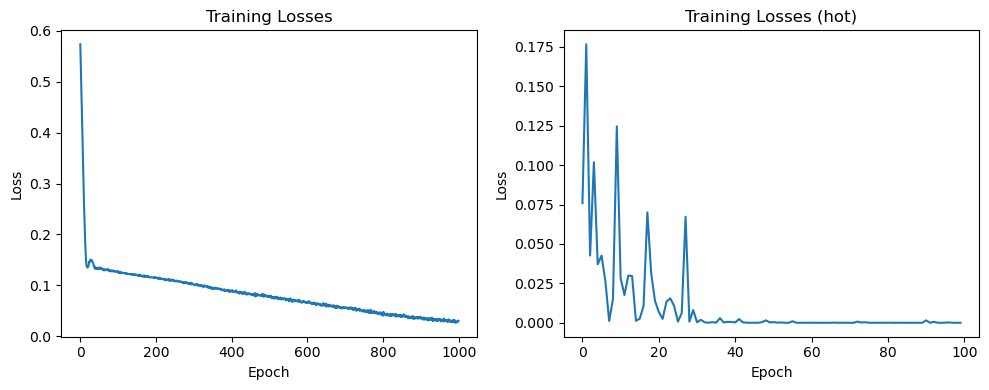

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Links: losses
axes[0].plot(losses)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Losses")

# Rechts: losses_hot
axes[1].plot(losses_hot)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training Losses (hot)")

plt.tight_layout()
plt.show()

The losses for model 2 are also located at much lower loss values than these for model 1, which can be seen much better in the following plot, which shows both in one graph.

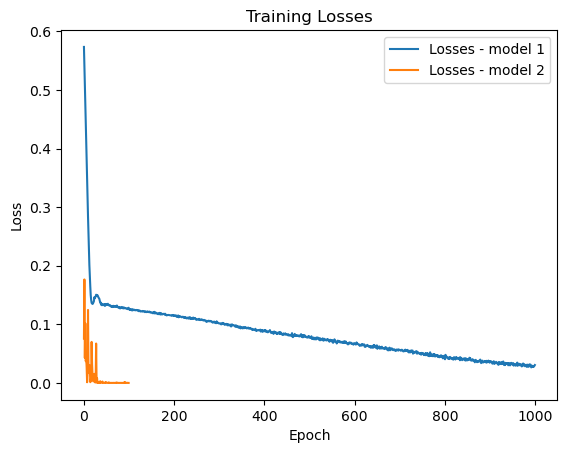

In [27]:
plt.plot(losses, label="Losses - model 1")
plt.plot(losses_hot, label="Losses - model 2")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

Now we want to have a deeper look into the actually predicted labels.

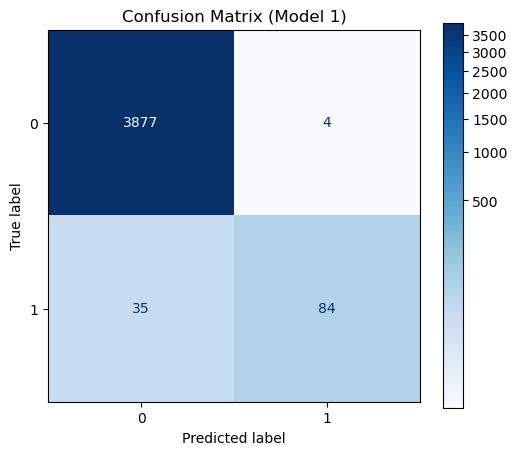

In [28]:
y_true_num = y_test_tensor_num.cpu().numpy().astype(int).ravel()
preds_num = preds_num.cpu().numpy().astype(int).ravel()
cm = confusion_matrix(y_true_num, preds_num)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True, im_kw={"norm": colors.PowerNorm(gamma=0.3)})
plt.title("Confusion Matrix (Model 1)")
plt.show()

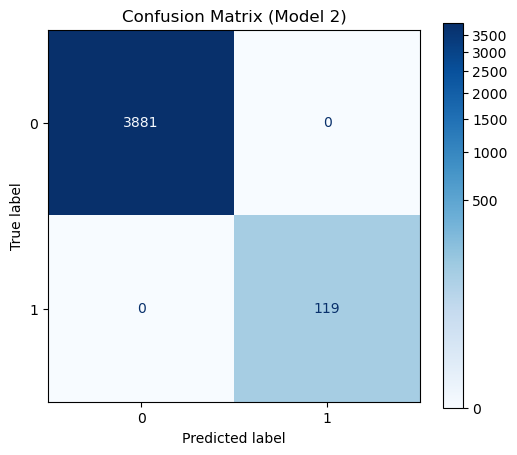

In [29]:
y_true_hot = y_test_tensor_hot.cpu().numpy().astype(int).ravel()
preds_hot = preds_hot.cpu().numpy().astype(int).ravel()

cm_hot = confusion_matrix(y_true_hot, preds_hot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_hot)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True, im_kw={"norm": colors.PowerNorm(gamma=0.3)})
plt.title("Confusion Matrix (Model 2)")
plt.show()

## 8 Discussion 
Provide a short reflection on model behavior and performance.